``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

## 6.1 ABテストの効果検証

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/6_1_AB%E3%83%86%E3%82%B9%E3%83%88%E5%8A%B9%E6%9E%9C%E6%A4%9C%E8%A8%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 6.1.1 問題設定
鈴木さんと佐藤さんはそれぞれ自分の担当のWebページに改善を加えました。  
改善後のページBと従来のページAをランダムに提示するABテストを実施し、効果検証をしました。  
その結果が以下の通りであった場合、それぞれの改善に効果があったかどうか判断したいということがビジネス上の課題と考えて下さい。


|                 |            | 鈴木さん | 山田さん |
| --------------- | ---------- | --------: | --------: |
| 従来のページA   | 表示数     | 40       | 1200     |
|                 | クリック数 | 2        | 60       |
|                 | クリック率 | 5%       | 5%       |
| 改善後のページB | 表示数     | 25       | 1500     |
|                 | クリック数 | 2        | 110      |
|                 | クリック率 | 8%       | 6.88%    |



### 6.1.2 確率モデル定義(鈴木さんケース)


#### 確率モデル定義と確率モデル構造可視化
最初に鈴木さんケースで分析する

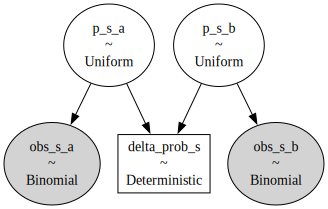

In [5]:
model_s = pm.Model()

with pm.Model() as model_s:
    # 事前分布として一様分布を採用
    p_s_a = pm.Uniform('p_s_a', lower=0.0, upper=1.0)
    p_s_b = pm.Uniform('p_s_b', lower=0.0, upper=1.0)

    # 二項分布で確率モデルを定義
    # n:表示数　observed:ヒット数　とすればよい
    obs_s_a = pm.Binomial('obs_s_a', p=p_s_a, n=40, observed=2)
    obs_s_b = pm.Binomial('obs_s_b', p=p_s_b, n=25, observed=2)

    # 新たな確率変数として二つの確率変数の差を定義
    delta_prob_s = pm.Deterministic('delta_prob_s', p_s_b - p_s_a)

# 確率モデル構造可視化
g = pm.model_to_graphviz(model_s)
display(g)

### 6.1.3 サンプリングと結果分析

#### サンプリング

In [6]:
with model_s:
    idata_s = pm.sample(random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_s_a, p_s_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


#### plot_trace関数で推論結果の確認

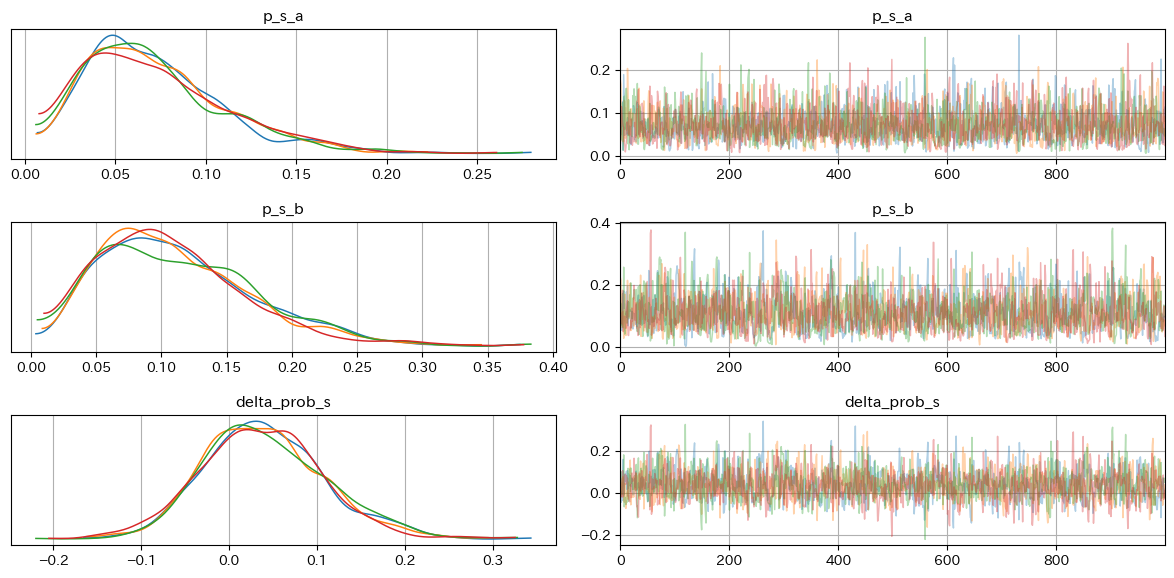

In [7]:
az.plot_trace(idata_s, compact=False)
plt.tight_layout();

#### delta_prob_sの分布を可視化

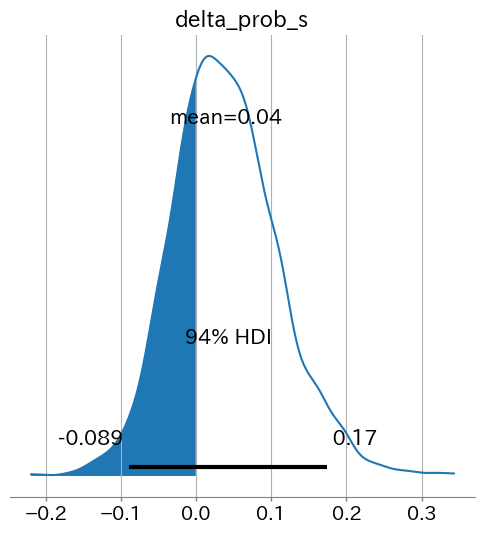

In [8]:
ax = az.plot_posterior(idata_s, var_names=['delta_prob_s'])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0]);

#### 画面Aの方がクリック率が高い確率を計算

In [9]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_s = idata_s['posterior'].data_vars['delta_prob_s']
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s/n_s
print(f'鈴木さんケース　画面Aの方がクリック率が高い確率: {n1_rate_s*100:.02f}%')

鈴木さんケース　画面Aの方がクリック率が高い確率: 29.33%


### 6.1.4 山田さんケースでABテスト効果検証

#### 確率モデル構築・サンプリング・結果分析

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_y_a, p_y_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


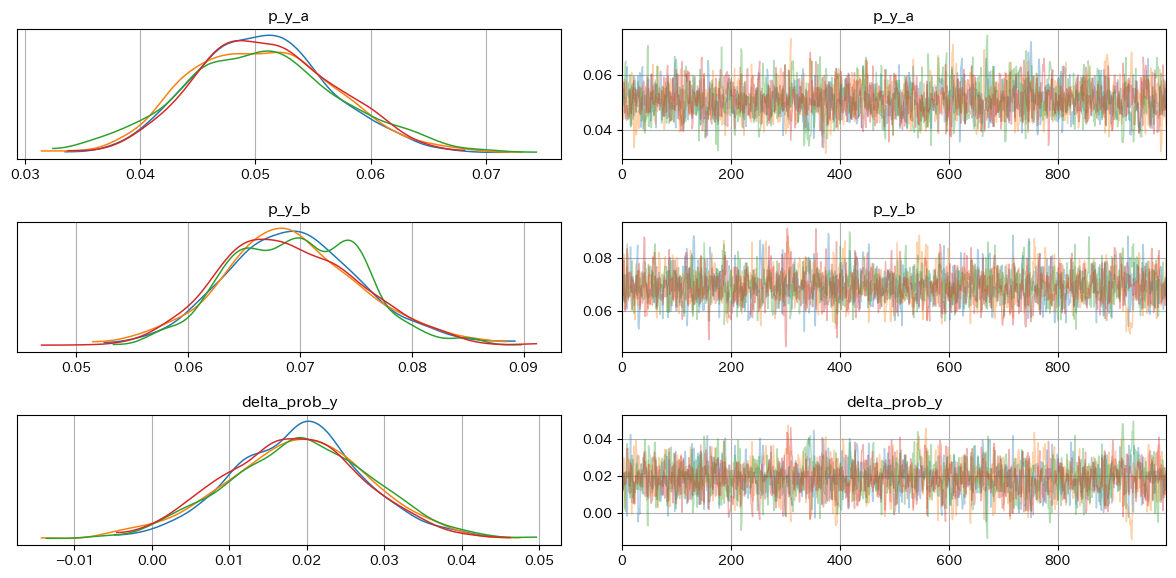

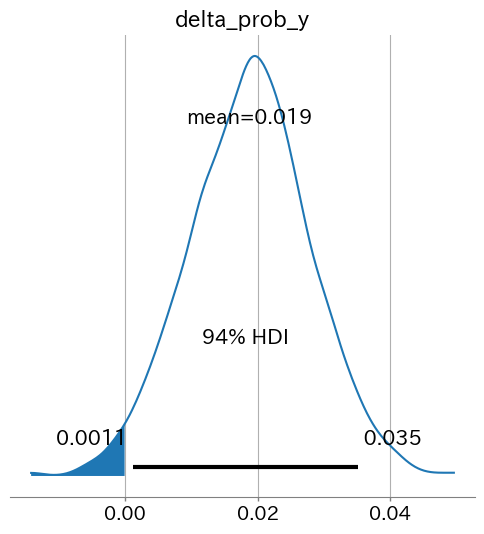

In [10]:
model_y = pm.Model()

with pm.Model() as model_y:
    # 事前分布として一様分布を採用
    p_y_a = pm.Uniform('p_y_a', lower=0.0, upper=1.0)
    p_y_b = pm.Uniform('p_y_b', lower=0.0, upper=1.0)

    # 二項分布で確率モデルを定義
    # n:表示数　observed:ヒット数　とすればよい
    obs_y_a = pm.Binomial('obs_y_a', p=p_y_a, n=1200, observed=60)
    obs_y_b = pm.Binomial('obs_y_b', p=p_y_b, n=1600, observed=110)

    # 新たな確率変数として二つの確率変数の差を定義
    delta_prob_y = pm.Deterministic('delta_prob_y', p_y_b - p_y_a)

# サンプリング
with model_y:
    idata_y = pm.sample(random_seed=42, target_accept=0.99)

# traceの確認
az.plot_trace(idata_y, compact=False)
plt.tight_layout();
plt.show()

# delta_prob_yの分布を可視化
ax = az.plot_posterior(idata_y, var_names=['delta_prob_y'])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0]);

In [11]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_y = idata_y['posterior'].data_vars['delta_prob_y']
delta_prob_y_values = delta_prob_y.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_y = (delta_prob_y_values < 0).sum()

# 全体サンプル数
n_y = len(delta_prob_y_values)

# 比率計算
n1_rate_y = n1_y/n_y

print(f'山田さんケース　画面Aの方がクリック率が高い確率: {n1_rate_y*100:.02f}%')

山田さんケース　画面Aの方がクリック率が高い確率: 2.05%


### 6.1.5 確率モデルを直接使った別解


#### 鈴木さんケース

Sampling: [p_a, p_b]


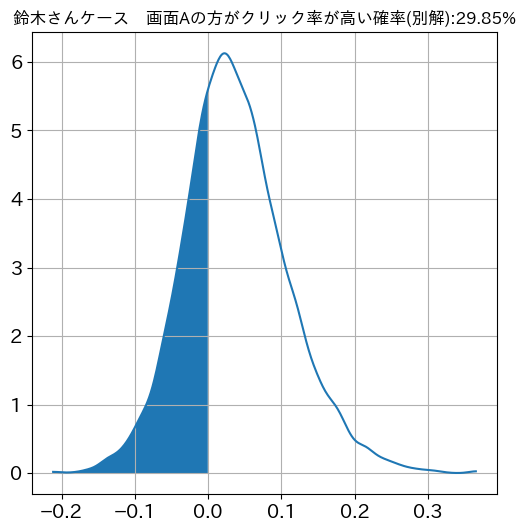

In [12]:
# 画面A 成功2回　失敗3８回
alpha_a = 2 + 1
beta_a = 38 + 1

# 画面B 成功2回　失敗23回
alpha_b = 2 + 1
beta_b = 23 + 1

model_s2 = pm.Model()
with model_s2:
    # 確率モデル定義
    # pm.Beta: ベータ分布
    # alpha: 注目している試行の成功数+1
    # beta: 注目している試行の失敗数+1
    p_a = pm.Beta('p_a', alpha=alpha_a, beta=beta_a)
    p_b = pm.Beta('p_b', alpha=alpha_b, beta=beta_b)

    # サンプル値取得
    samples_s2 = pm.sample_prior_predictive(random_seed=42, samples=10000)

# サンプル値抽出
p_a_samples_s2 = samples_s2['prior']['p_a'].values.reshape(-1)
p_b_samples_s2 = samples_s2['prior']['p_b'].values.reshape(-1)
delta_a_b_s2 = p_b_samples_s2 - p_a_samples_s2

# delta_probの値がマイナスであった件数
n1_s2 = (delta_a_b_s2 < 0).sum()

# 全体サンプル数
n_s2 = len(delta_a_b_s2)

# 比率計算
n1_rate_s2 = n1_s2/n_s2

# 可視化
ax = az.plot_dist(delta_a_b_s2)
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0])

# グラフタイトル
title = f'鈴木さんケース　画面Aの方がクリック率が高い確率(別解):\
{n1_rate_s2*100:.02f}%'
ax.set_title(title, fontsize=12);

#### 山田さんケース

Sampling: [p_a, p_b]


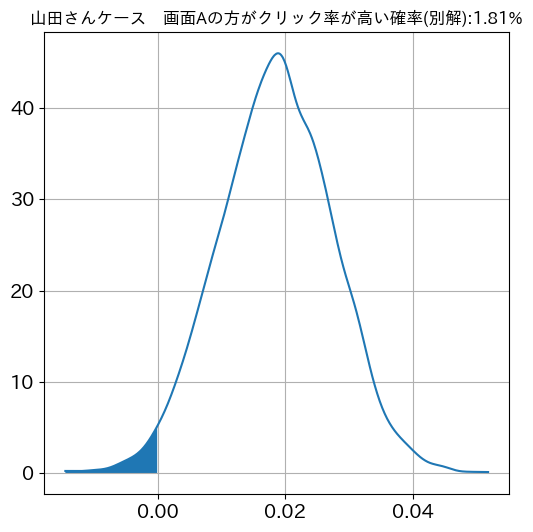

In [13]:
# A 成功60回　失敗1140回
alpha_a = 60 + 1
beta_a = 1140 + 1

# B 成功110回　失敗1490回
alpha_b = 110 + 1
beta_b = 1490 + 1

model_y2 = pm.Model()
with model_y2:
    # 確率モデル定義
    # pm.Beta: ベータ分布
    # alpha: 注目している試行の成功数+1
    # beta: 注目している試行の失敗数+1
    p_a = pm.Beta('p_a', alpha=alpha_a, beta=beta_a)
    p_b = pm.Beta('p_b', alpha=alpha_b, beta=beta_b)

    # サンプル値取得
    samples_y2 = pm.sample_prior_predictive(random_seed=42, samples=10000)

# サンプル値抽出
p_a_samples_y2 = samples_y2['prior']['p_a'].values.reshape(-1)
p_b_samples_y2 = samples_y2['prior']['p_b'].values.reshape(-1)
delta_a_b_y2 = p_b_samples_y2 - p_a_samples_y2

# delta_probの値がマイナスであった件数
n1_y2 = (delta_a_b_y2 < 0).sum()

# 全体サンプル数
n_y2 = len(delta_a_b_y2)

# 比率計算
n1_rate_y2 = n1_y2/n_y2

# 可視化
ax = az.plot_dist(delta_a_b_y2)
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0])

# グラフタイトル
title = f'山田さんケース　画面Aの方がクリック率が高い確率(別解):\
{n1_rate_y2*100:.02f}%'
ax.set_title(title, fontsize=12);

#### バージョンの確認

In [14]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

seaborn            : 0.12.2
arviz              : 0.17.1
numpy              : 1.26.4
pandas             : 2.2.1
pymc               : 5.11.0
matplotlib         : 3.8.3
japanize_matplotlib: 1.1.3

